In [1]:
!pip install pyspark



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
import os
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd



In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

In [4]:
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

## Loading the datasets

In [5]:
col_mat_nuw_dataset = spark.read.csv("dataset\col_mat_nuw_output.csv", header=False, inferSchema=True)
mon_kur_jaf_dataset = spark.read.csv("dataset\kan_output.csv", header=False, inferSchema=True)
kan_dataset = spark.read.csv("dataset\mon_kur_jaf_output.csv", header=False, inferSchema=True)

col_mat_nuw_dataset = col_mat_nuw_dataset.toDF("HCHO reading", "Location", "Current Date", "Next Date")
mon_kur_jaf_dataset = mon_kur_jaf_dataset.toDF("HCHO reading", "Location", "Current Date", "Next Date")
kan_dataset = kan_dataset.toDF("HCHO reading", "Location", "Current Date", "Next Date")

col_mat_nuw_dataset.show()
mon_kur_jaf_dataset.show()
kan_dataset.show()

+--------------------+--------------+------------+----------+
|        HCHO reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

In [6]:
col_mat_nuw_dataset.printSchema()
mon_kur_jaf_dataset.printSchema()
kan_dataset.printSchema()

root
 |-- HCHO reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)

root
 |-- HCHO reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)

root
 |-- HCHO reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)



In [7]:
from pyspark.sql.functions import col, sum

# Sum null values for each column
for dataset in [col_mat_nuw_dataset, mon_kur_jaf_dataset, kan_dataset]:
    null_counts = dataset.select([sum(col(c).isNull().cast("int")).alias(c) for c in dataset.columns])
    # Convert to Pandas DataFrame for easier display
    null_counts_pd = null_counts.toPandas()
    print("Null value counts for each column:")
    print(null_counts_pd)

Null value counts for each column:
   HCHO reading  Location  Current Date  Next Date
0          2419         0             0          0
Null value counts for each column:
   HCHO reading  Location  Current Date  Next Date
0           793         0             0          0
Null value counts for each column:
   HCHO reading  Location  Current Date  Next Date
0          1652         0             0          0


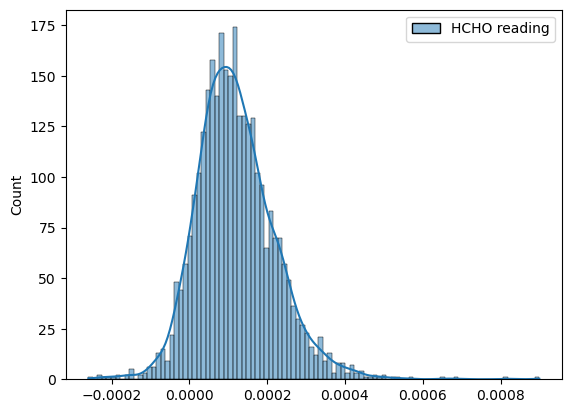

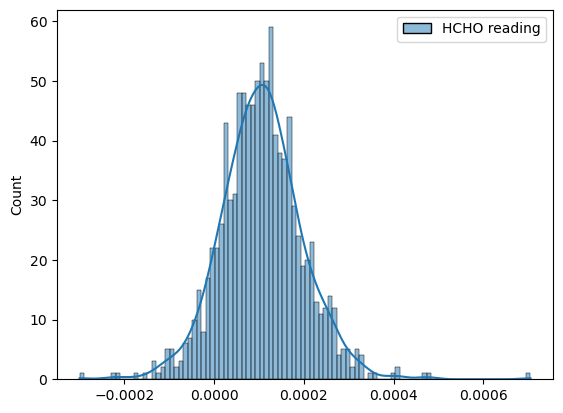

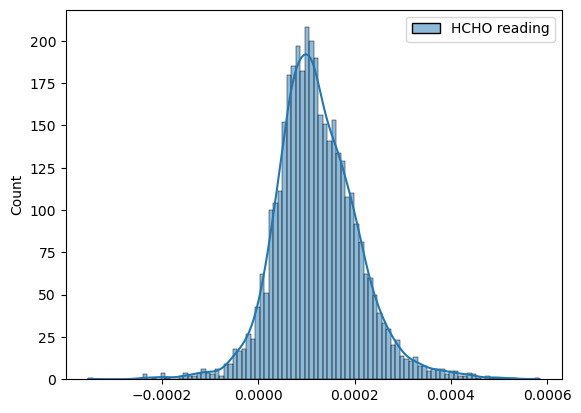

In [8]:


for dataset in [col_mat_nuw_dataset, mon_kur_jaf_dataset, kan_dataset]:
    # Convert PySpark DataFrame to Pandas DataFrame for plotting
    dataset_pd = dataset.toPandas()

    # Plot histograms for each numeric column
    sns.histplot(data=dataset_pd, bins=100, kde=True)
    plt.show()

In [9]:
concatenated_df = col_mat_nuw_dataset.union(mon_kur_jaf_dataset).union(kan_dataset)
concatenated_df.show()

+--------------------+--------------+------------+----------+
|        HCHO reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

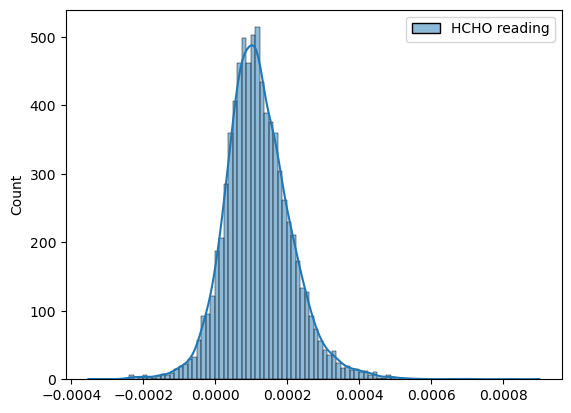

In [10]:
dataset_pd = concatenated_df.toPandas()
# Plot histograms for each numeric column
sns.histplot(data=dataset_pd, bins=100, kde=True)
plt.show()

In [11]:
def fill_with_last_and_next(df, ordering_column, column_name):
    # Define window specifications
    forward_window = Window.orderBy(ordering_column).rowsBetween(Window.unboundedPreceding, 0)
    backward_window = Window.orderBy(ordering_column).rowsBetween(0, Window.unboundedFollowing)
    
    # Fill null values with the last observation forward
    filled_df_forward = df.withColumn(column_name, F.last(column_name, True).over(forward_window))
    
    # Fill null values with the next observation backward
    filled_df_backward = filled_df_forward.withColumn(column_name, F.first(column_name, True).over(backward_window))
    
    return filled_df_backward

# Apply the custom function to your concatenated DataFrame
filled_df_custom = fill_with_last_and_next(concatenated_df, "Current Date", "HCHO reading")

# Show the resulting DataFrame
filled_df_custom.show()


+--------------------+-------------------+------------+----------+
|        HCHO reading|           Location|Current Date| Next Date|
+--------------------+-------------------+------------+----------+
|1.969834395781014...|     Colombo Proper|  2019-01-01|2019-01-02|
|1.969834395781014...|   Deniyaya, Matara|  2019-01-01|2019-01-02|
|1.969834395781014...|Nuwara Eliya Proper|  2019-01-01|2019-01-02|
|1.760713459877335...|       Kandy Proper|  2019-01-01|2019-01-02|
|1.760713459877335...| Bibile, Monaragala|  2019-01-01|2019-01-02|
|8.829725542537962E-5|  Kurunegala Proper|  2019-01-01|2019-01-02|
|5.830909719406619E-5|      Jaffna Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|     Colombo Proper|  2019-01-02|2019-01-03|
|5.803530712000793E-6|   Deniyaya, Matara|  2019-01-02|2019-01-03|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|
|9.220391253917748E-5|       Kandy Proper|  2019-01-02|2019-01-03|
|1.919914652467399E-5| Bibile, Monaragala|  2019-01-02|2019-01

In [12]:
filled_df_custom.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in filled_df_custom.columns]).show()

+------------+--------+------------+---------+
|HCHO reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



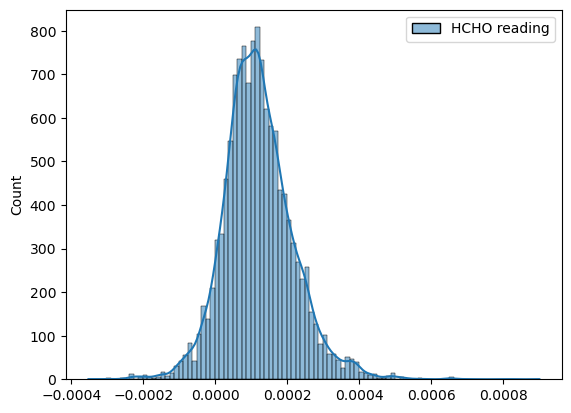

In [13]:
# Plot histograms for each numeric column
sns.histplot(data=filled_df_custom.toPandas(), bins=100, kde=True)
plt.show()

In [14]:
filled_df_custom.count()

12782

In [15]:
filled_df_custom.describe('HCHO reading').show()


+-------+--------------------+
|summary|        HCHO reading|
+-------+--------------------+
|  count|               12782|
|   mean|1.198404653912504...|
| stddev|9.705031733582523E-5|
|    min|-3.52473024357239...|
|    max|8.997101837438971E-4|
+-------+--------------------+



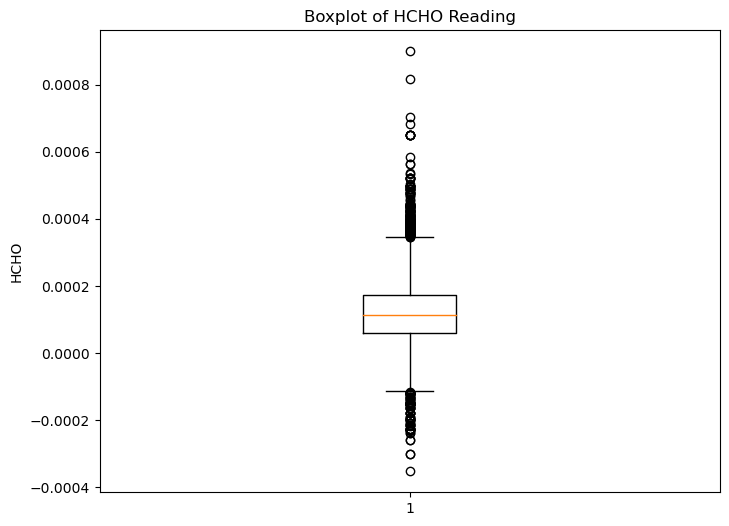

In [16]:

plt.figure(figsize=(8,6))
plt.boxplot(filled_df_custom.toPandas()['HCHO reading'])
plt.title("Boxplot of HCHO Reading")
plt.ylabel('HCHO')
plt.show()

In [17]:


def handle_outliers_zscore(df, column_name, threshold):
    # Calculate mean and standard deviation of the column
    mean_value = df.select(F.mean(column_name)).collect()[0][0]
    stddev_value = df.select(F.stddev(column_name)).collect()[0][0]
    
    # Calculate Z-score for the column
    df_with_zscore = df.withColumn("z_score", F.abs((F.col(column_name) - mean_value) / stddev_value))
    
    # Define a window specification to calculate mean excluding outliers
    outlier_window = Window.partitionBy().orderBy("z_score")
    
    # Calculate mean of non-outlier values (where z_score <= threshold)
    mean_non_outliers = F.avg(F.when(F.col("z_score") <= threshold, F.col(column_name))).over(outlier_window)
    
    # Replace outliers based on the defined threshold
    handled_df = df_with_zscore.withColumn(column_name,
                                           F.when(F.col("z_score") > threshold, mean_non_outliers)
                                           .otherwise(F.col(column_name)))
    
    # Remove the temporary z_score column
    handled_df = handled_df.drop("z_score")
    
    return handled_df

# Define the threshold for identifying outliers based on z-score (e.g., 3)
zscore_threshold = 3

# Apply the Z-Score method to handle outliers in the filled_df_custom dataset
handled_df_custom = handle_outliers_zscore(filled_df_custom, "HCHO reading", zscore_threshold)

# Show the resulting DataFrame
handled_df_custom.show()


+--------------------+-------------------+------------+----------+
|        HCHO reading|           Location|Current Date| Next Date|
+--------------------+-------------------+------------+----------+
|1.198442598720546...|Nuwara Eliya Proper|  2022-10-25|2022-10-26|
|1.198442598720546...|       Kandy Proper|  2022-10-25|2022-10-26|
|1.198471071494594...|     Colombo Proper|  2022-09-26|2022-09-27|
|1.198322757837731...|  Kurunegala Proper|  2022-08-12|2022-08-13|
|1.198522055357396...|      Jaffna Proper|  2022-10-26|2022-10-27|
|1.198211552810055...|  Kurunegala Proper|  2021-06-21|2021-06-22|
|1.198655891988558...|   Deniyaya, Matara|  2023-03-09|2023-03-10|
|1.197921551961852...|   Deniyaya, Matara|  2020-08-25|2020-08-26|
|1.197921551961852...|Nuwara Eliya Proper|  2020-08-25|2020-08-26|
|1.197896427536677...|       Kandy Proper|  2020-03-28|2020-03-29|
|1.197765248810660...|      Jaffna Proper|  2023-06-23|2023-06-24|
|1.197492585854607...|Nuwara Eliya Proper|  2019-11-06|2019-11

In [18]:
handled_df_custom.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in handled_df_custom.columns]).show()

+------------+--------+------------+---------+
|HCHO reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



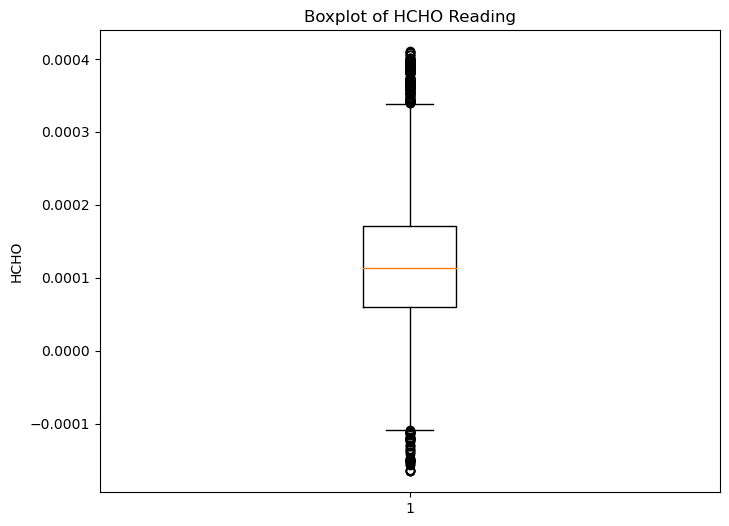

In [19]:
plt.figure(figsize=(8,6))
plt.boxplot(handled_df_custom.toPandas()['HCHO reading'])
plt.title("Boxplot of HCHO Reading")
plt.ylabel('HCHO')
plt.show()

In [20]:
print("Before handeling outliers")
filled_df_custom.describe('HCHO reading').show()
print("After handeling outliers")
handled_df_custom.describe('HCHO reading').show()


Before handeling outliers
+-------+--------------------+
|summary|        HCHO reading|
+-------+--------------------+
|  count|               12782|
|   mean|1.198404653912504...|
| stddev|9.705031733582523E-5|
|    min|-3.52473024357239...|
|    max|8.997101837438971E-4|
+-------+--------------------+

After handeling outliers
+-------+--------------------+
|summary|        HCHO reading|
+-------+--------------------+
|  count|               12782|
|   mean|1.183576157414945...|
| stddev|8.985334993436357E-5|
|    min|-1.65262265757553...|
|    max|4.105507403533942E-4|
+-------+--------------------+



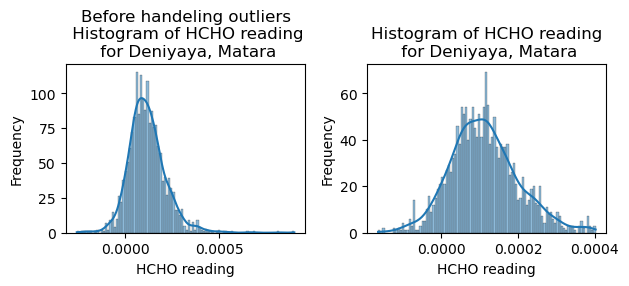

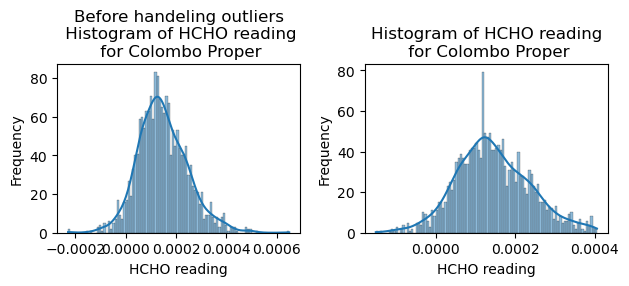

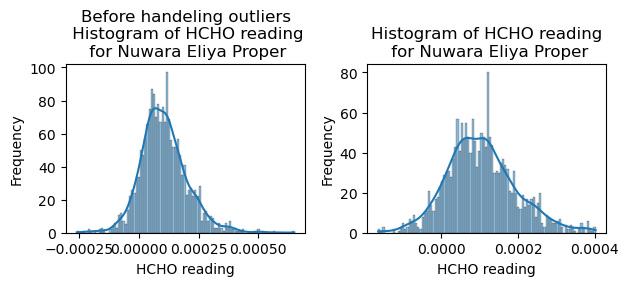

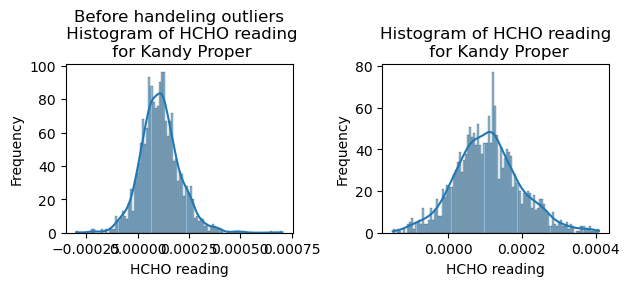

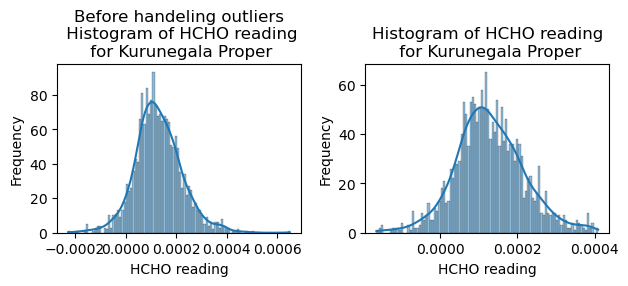

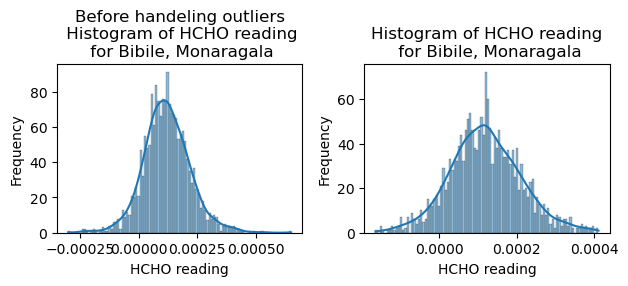

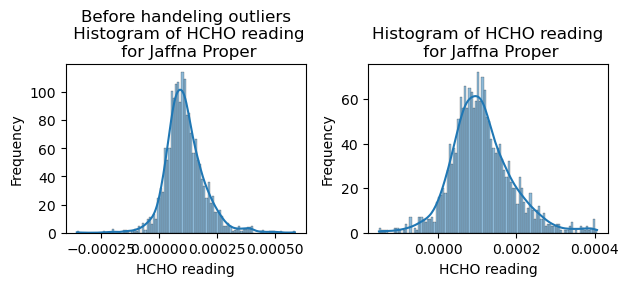

In [21]:
location = handled_df_custom.select("Location").distinct()
locations = [row.Location for row in location.collect()]

# Convert PySpark DataFrame to Pandas DataFrame
dataset_pd = handled_df_custom.toPandas()
df = filled_df_custom.toPandas()


# Iterate over each unique location
for place in locations:
    # Filter the dataset for the current location
    location_data = dataset_pd[dataset_pd['Location'] == place]
    ld= df[df['Location'] == place]
    # Plot histograms for each numeric column in the filtered dataset
    for column in dataset_pd.select_dtypes(include='number').columns:
        plt.subplot(2, 2, 1)
        sns.histplot(data=ld[column], bins=100, kde=True)
        plt.title(f'Before handeling outliers\n Histogram of {column}\n for {place}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.subplot(2, 2, 2)
        sns.histplot(data=location_data[column], bins=100, kde=True)
        plt.title(f'Histogram of {column}\n for {place}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
         
    plt.tight_layout()
    plt.show()   





In [22]:
# Calculate descriptive statistics for each location
stats_per_location = handled_df_custom.groupBy("Location").agg(
    F.mean("HCHO reading").alias("Mean_HCHO"),
    F.median("HCHO reading").alias("Median_HCHO"),
    F.stddev("HCHO reading").alias("StdDev_HCHO")
)

# Calculate descriptive statistics across the entire dataset
overall_stats = handled_df_custom.agg(
    F.mean("HCHO reading").alias("Overall_Mean_HCHO"),
    F.median("HCHO reading").alias("Overall_Median_HCHO"),
    F.stddev("HCHO reading").alias("Overall_StdDev_HCHO")
)

# Show descriptive statistics for each location
print("Descriptive Statistics for Each Location:")
stats_per_location.show(truncate=False)

# Show descriptive statistics across the entire dataset
print("\nDescriptive Statistics Across the Entire Dataset:")
overall_stats.show(truncate=False)

Descriptive Statistics for Each Location:
+-------------------+---------------------+---------------------+--------------------+
|Location           |Mean_HCHO            |Median_HCHO          |StdDev_HCHO         |
+-------------------+---------------------+---------------------+--------------------+
|Nuwara Eliya Proper|1.0403039095802186E-4|9.871015510752351E-5 |9.070995010034027E-5|
|Kandy Proper       |1.0820828404365904E-4|1.0599903350163236E-4|9.055993672769853E-5|
|Colombo Proper     |1.4462222170801887E-4|1.3547731526612476E-4|9.245719081551822E-5|
|Kurunegala Proper  |1.2898074404582119E-4|1.2214501862392485E-4|8.906447147354571E-5|
|Jaffna Proper      |1.1089565274547921E-4|1.0339499175594983E-4|7.789310030356982E-5|
|Deniyaya, Matara   |1.1274467175425612E-4|1.0787347365412389E-4|8.892628242713242E-5|
|Bibile, Monaragala |1.1902134493520747E-4|1.1779805227061312E-4|9.196327903127464E-5|
+-------------------+---------------------+---------------------+--------------------+



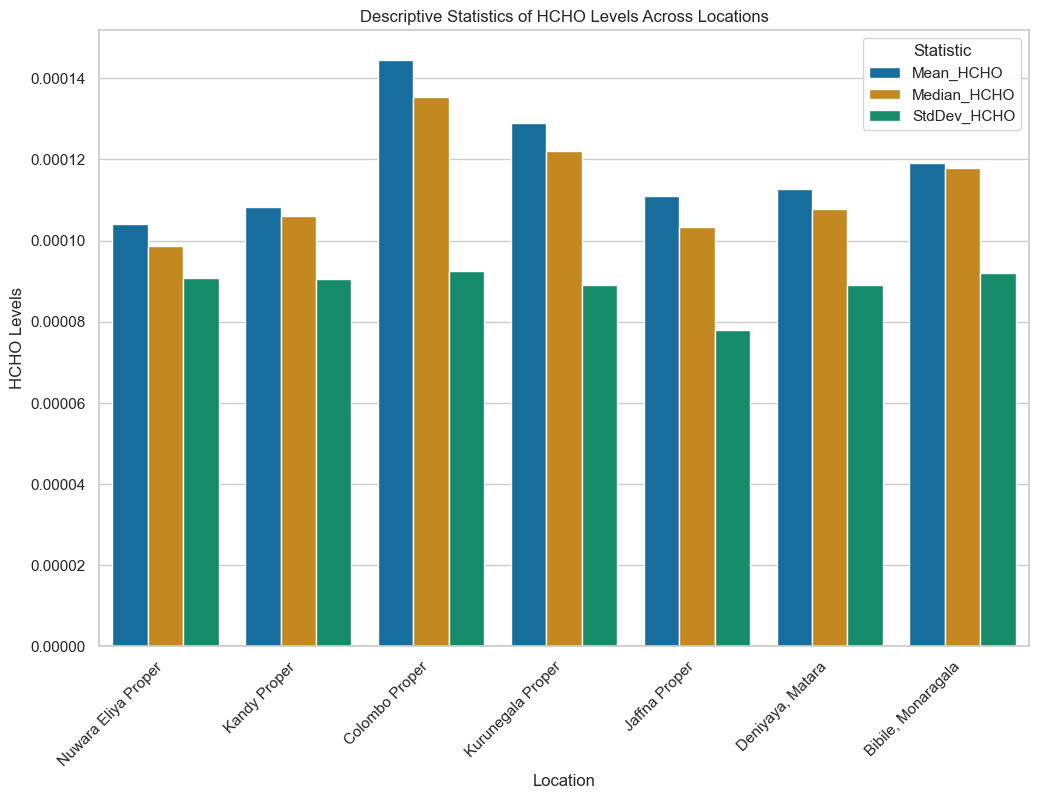

In [23]:
stats_per_location_pd = stats_per_location.toPandas()

# Set figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create a grouped bar plot using seaborn
sns.barplot(
    data=stats_per_location_pd.melt(id_vars="Location"),
    x="Location",
    y="value",
    hue="variable",
    palette="colorblind"
)

# Set plot labels and title
plt.xlabel("Location")
plt.ylabel("HCHO Levels")
plt.title("Descriptive Statistics of HCHO Levels Across Locations")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.legend(title="Statistic")  # Add legend with statistic types (mean, median, std dev)

# Show the plot
plt.show()

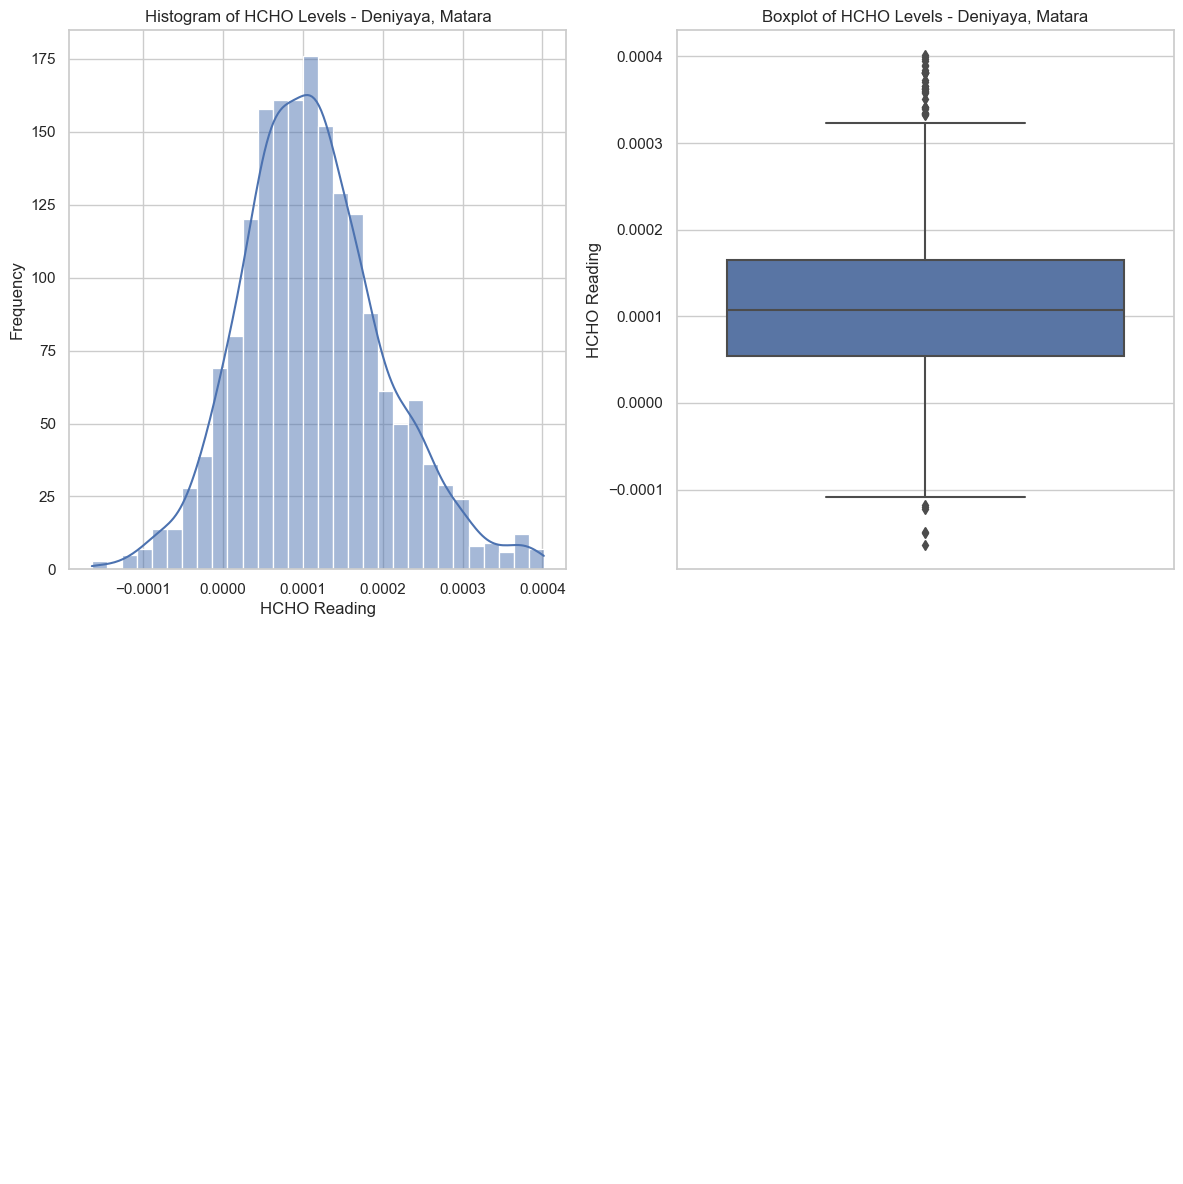

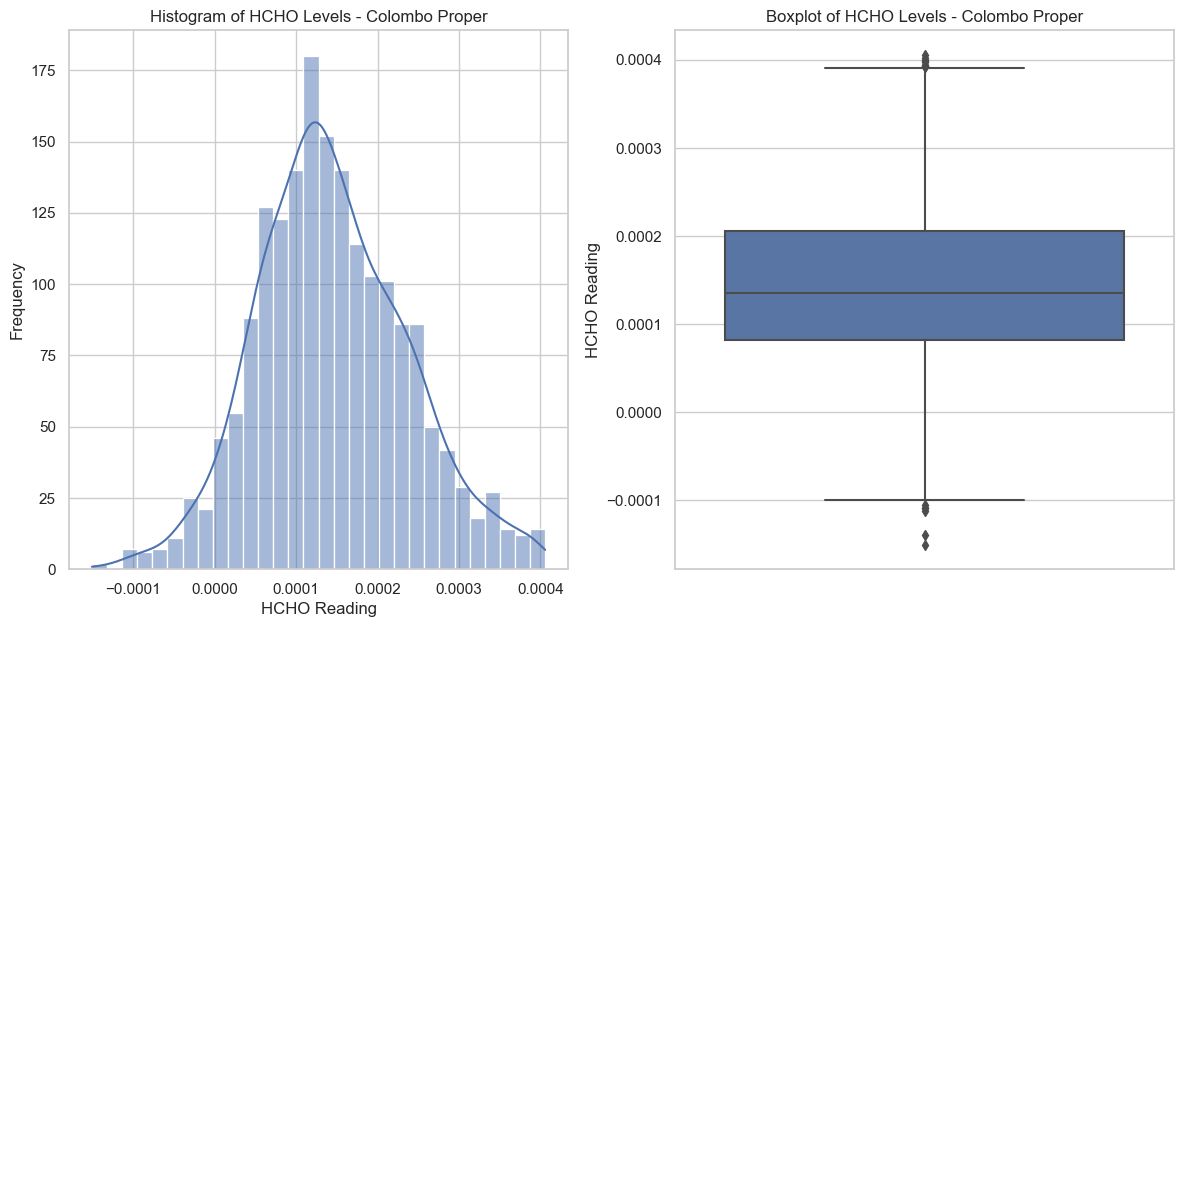

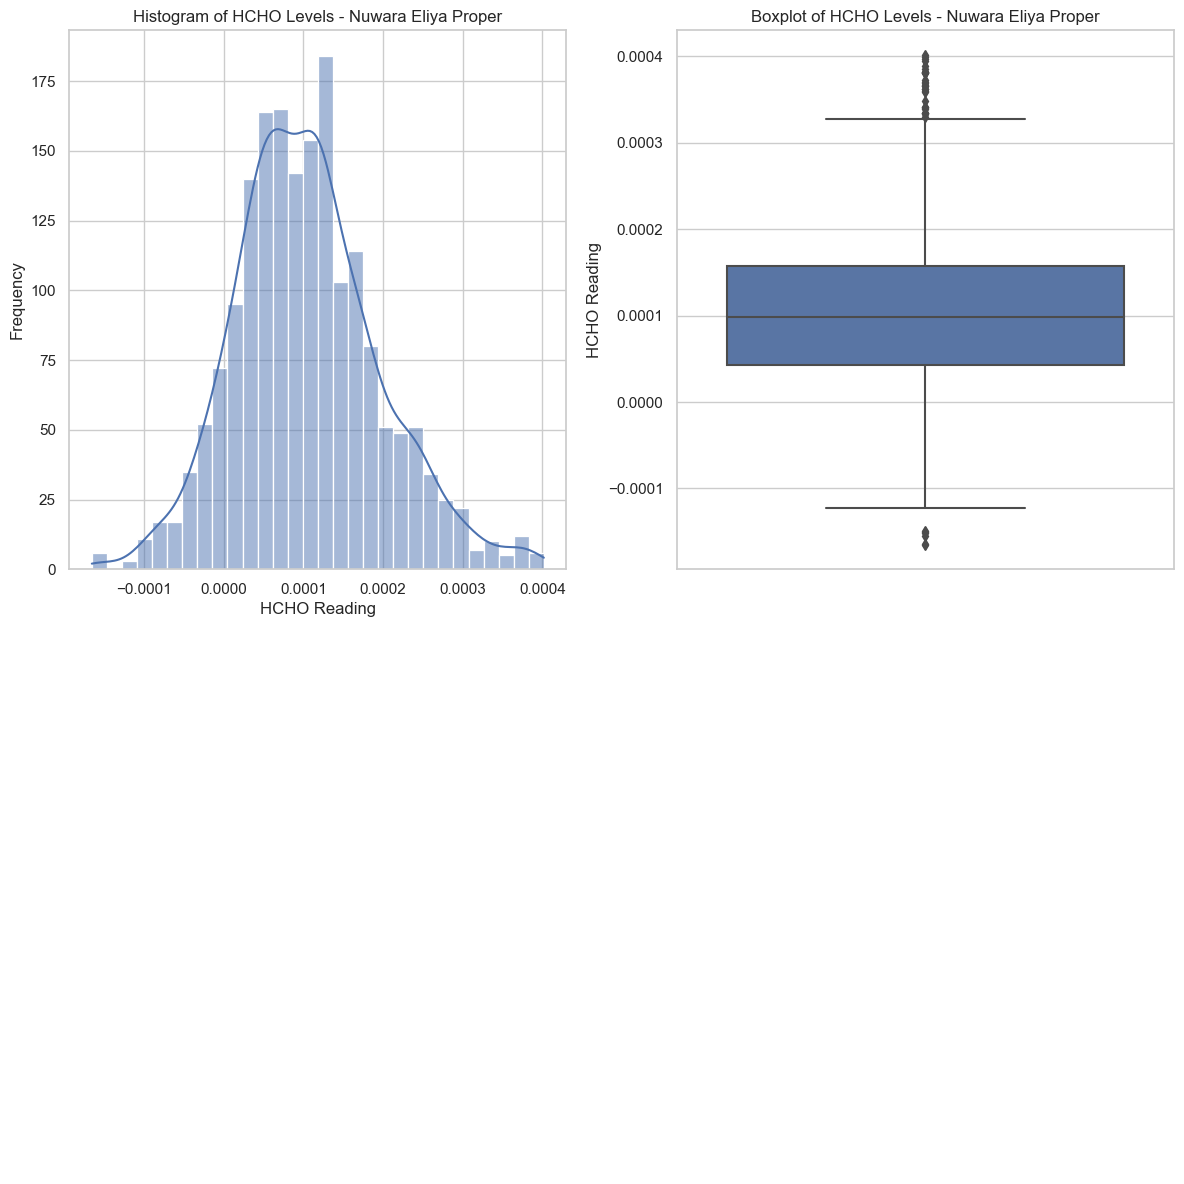

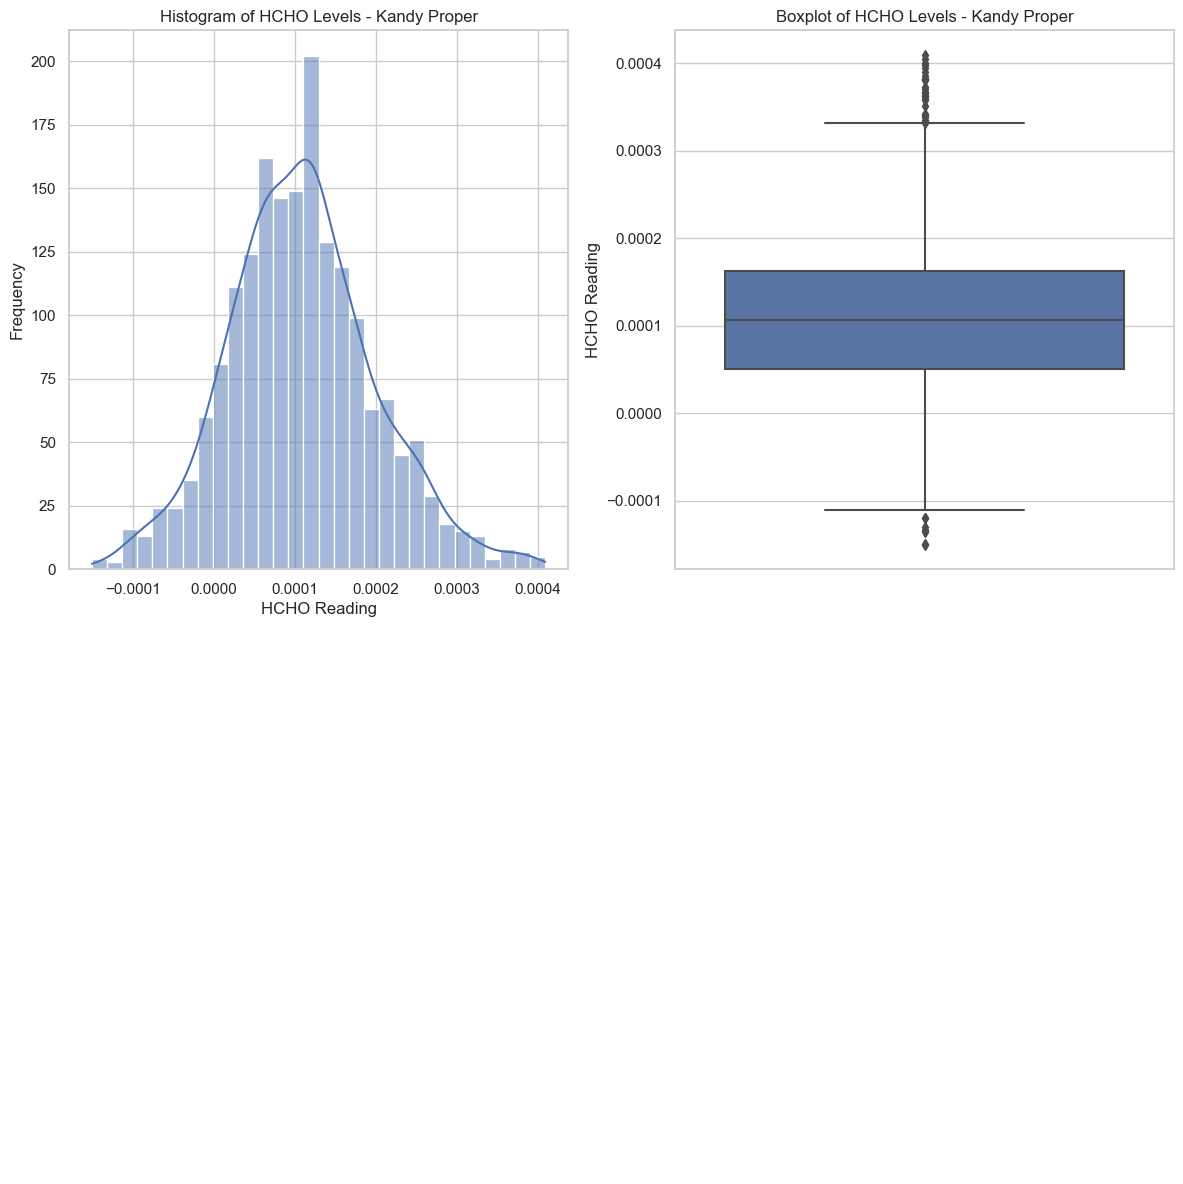

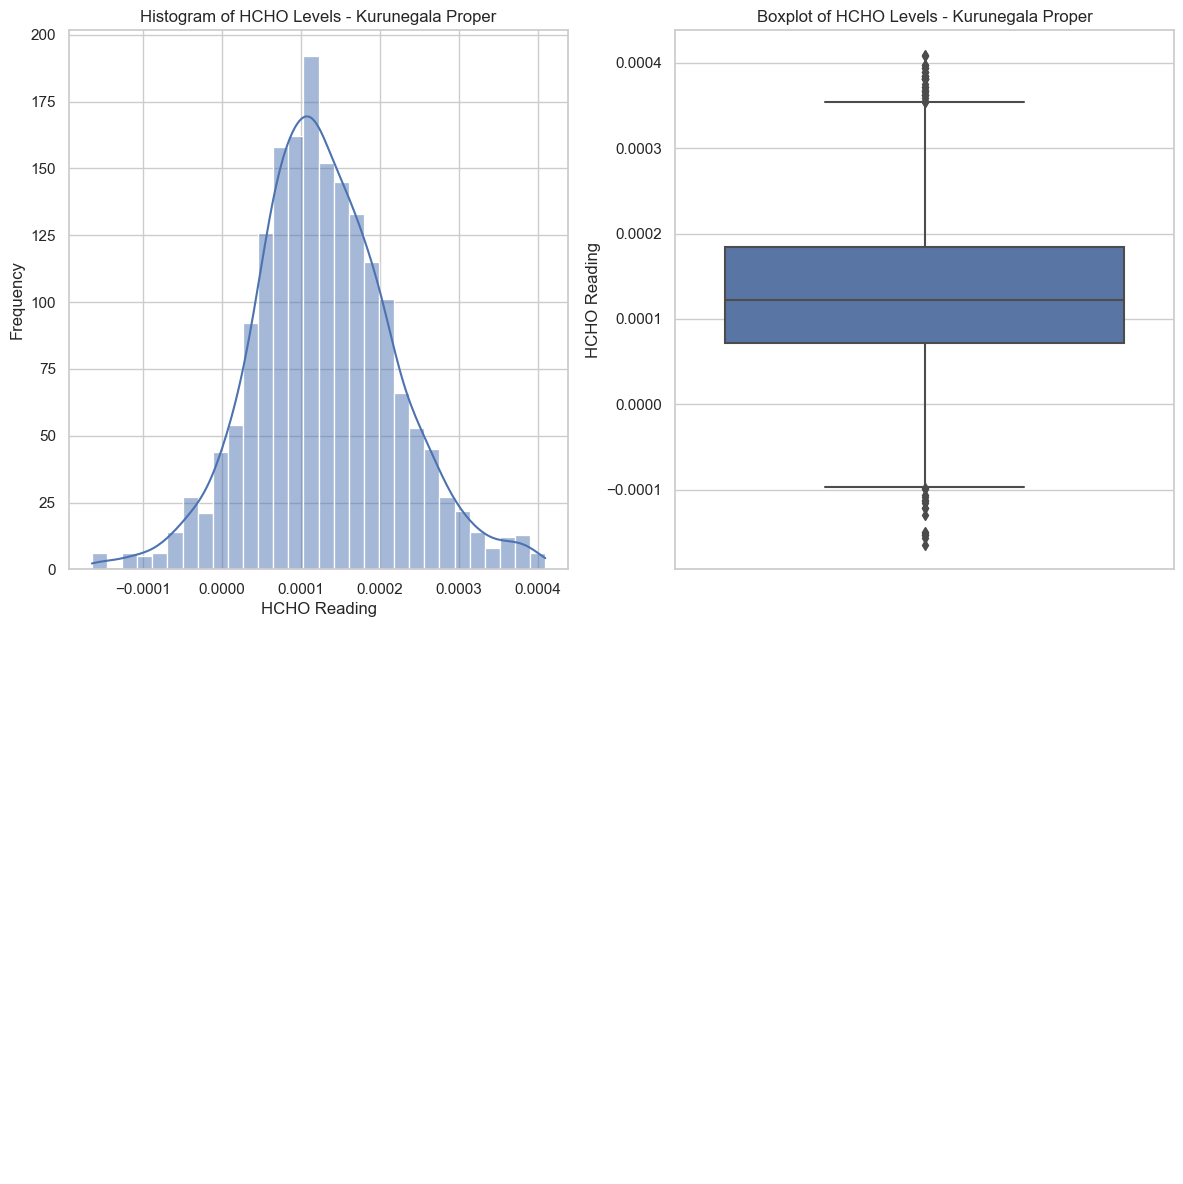

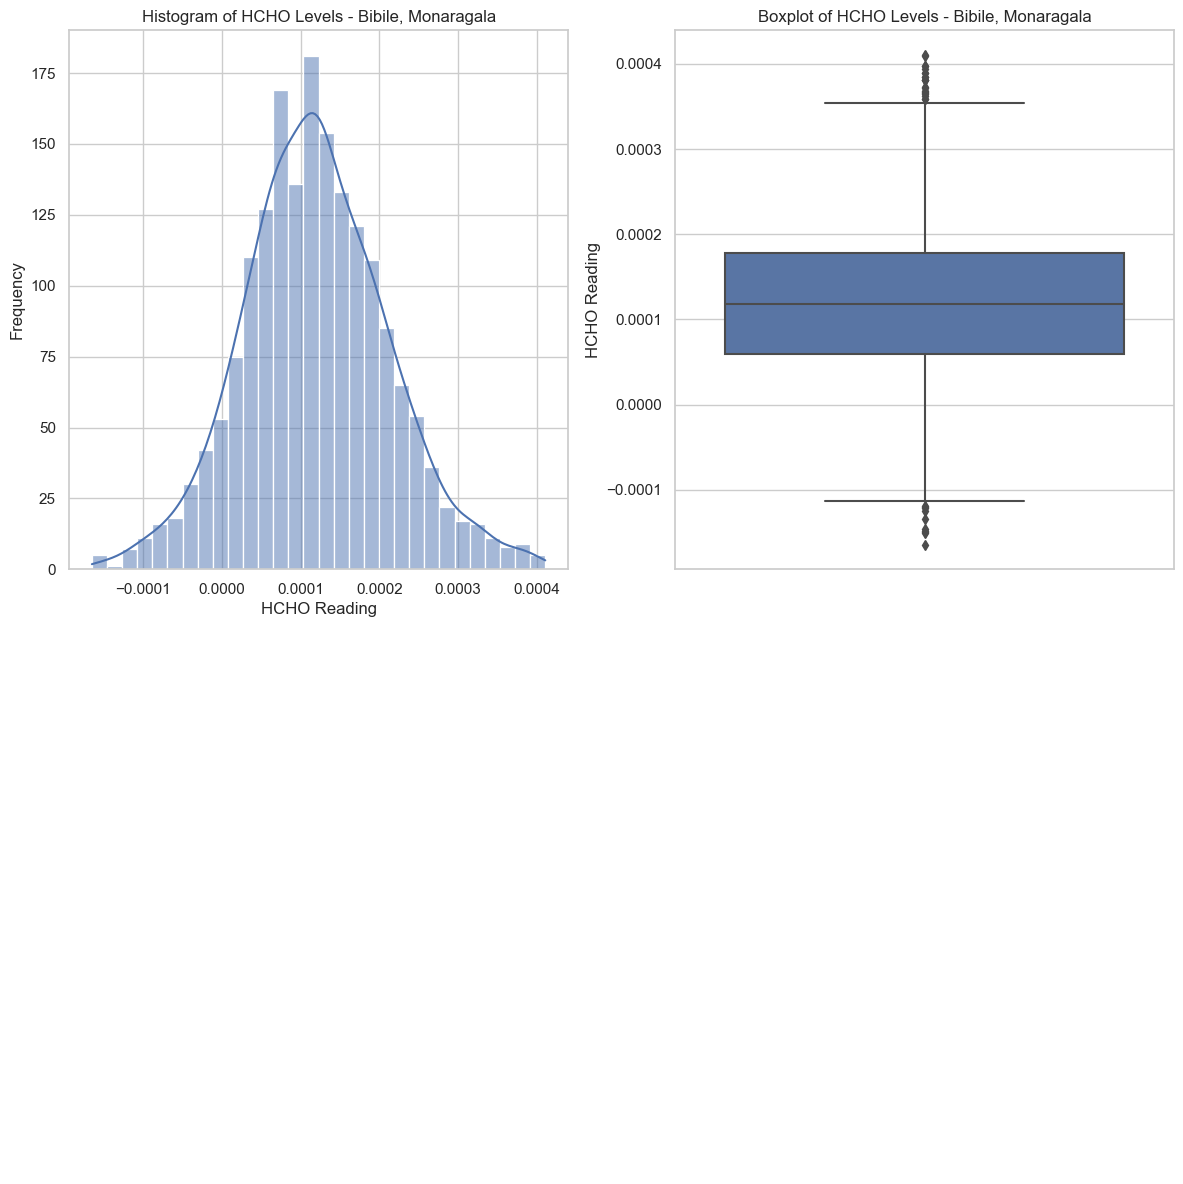

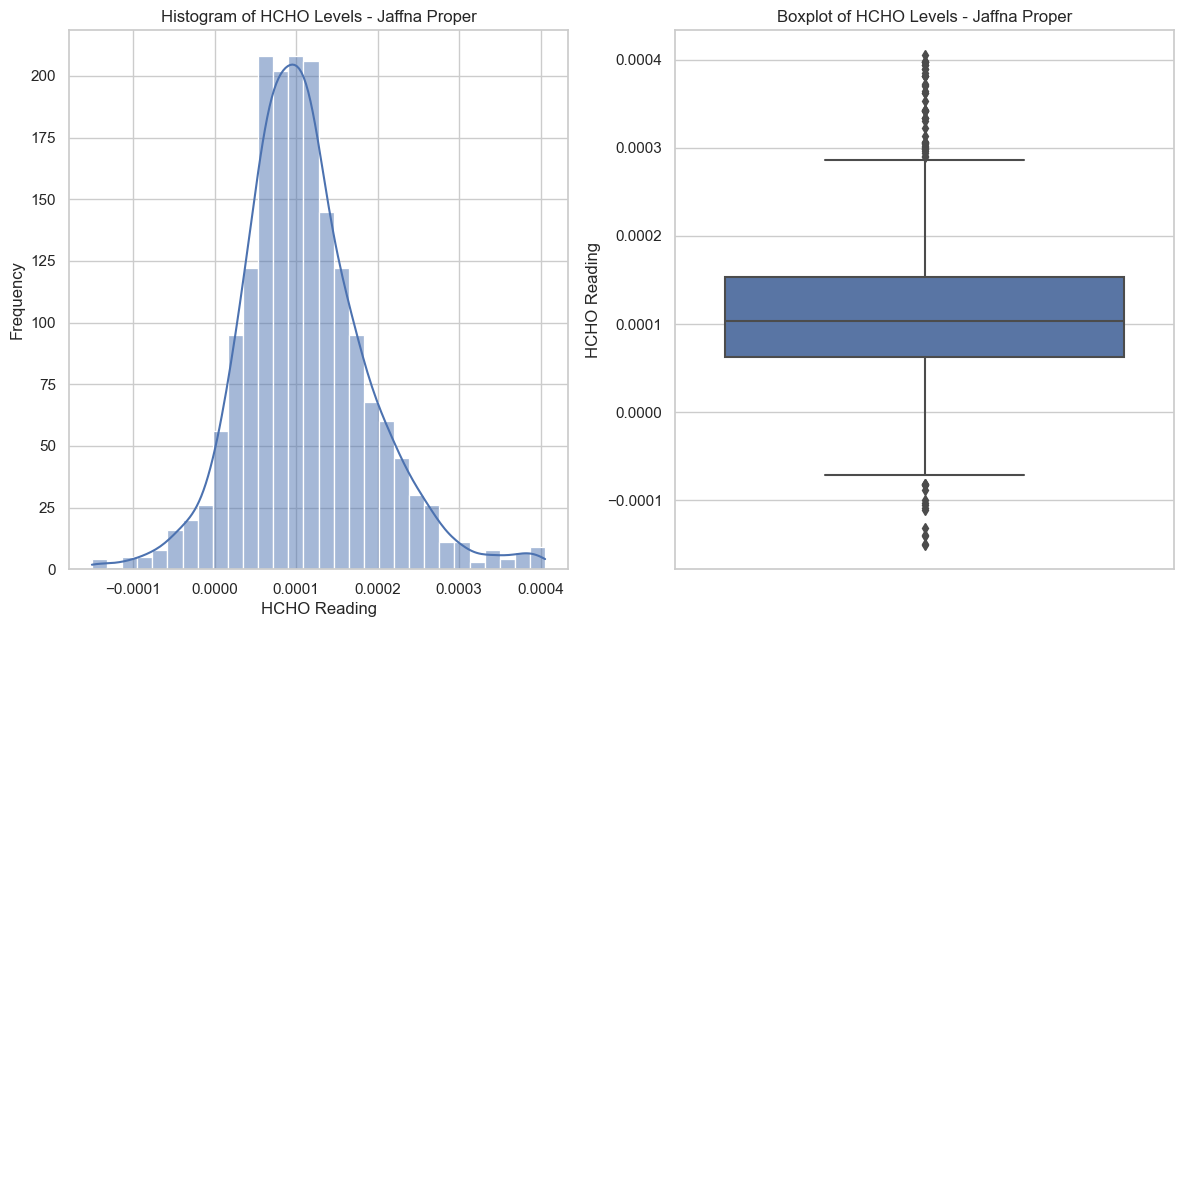

In [24]:
# Collect unique locations from the PySpark DataFrame
locations = [row.Location for row in location.collect()]

# Iterate over each unique location
for place in locations:
    # Filter the dataset for the current location
    location_data = dataset_pd[dataset_pd['Location'] == place]

    # Set up a figure with subplots for multiple visualizations
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Create a histogram of HCHO levels for the current location
    sns.histplot(data=location_data, x='HCHO reading', bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title(f'Histogram of HCHO Levels - {place}')
    axes[0, 0].set_xlabel('HCHO Reading')
    axes[0, 0].set_ylabel('Frequency')

    # Create a boxplot of HCHO levels for the current location
    sns.boxplot(data=location_data, y='HCHO reading', ax=axes[0, 1])
    axes[0, 1].set_title(f'Boxplot of HCHO Levels - {place}')
    axes[0, 1].set_ylabel('HCHO Reading')

    # Hide the unused subplots (axes[1, 0] and axes[1, 1])
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')

    # Adjust layout and display the plots
    fig.tight_layout()
    plt.show()

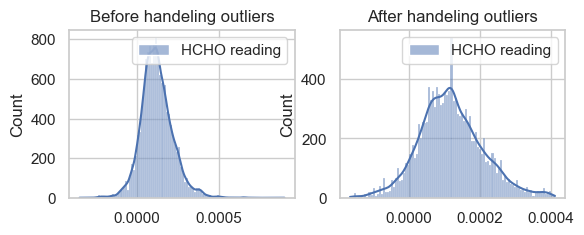

In [25]:
# Plot histograms for each numeric column
plt.subplot(2, 2, 1)
sns.histplot(data=filled_df_custom.toPandas(), bins=100, kde=True)
plt.title(f'Before handeling outliers')

plt.subplot(2, 2, 2)
sns.histplot(data=handled_df_custom.toPandas(), bins=100, kde=True)
plt.title(f'After handeling outliers')
plt.show()

In [26]:
dataset_pd

,HCHO reading,Location,Current Date,Next Date
0,0.000120,Nuwara Eliya Proper,2022-10-25,2022-10-26
1,0.000120,Kandy Proper,2022-10-25,2022-10-26
2,0.000120,Colombo Proper,2022-09-26,2022-09-27
3,0.000120,Kurunegala Proper,2022-08-12,2022-08-13
4,0.000120,Jaffna Proper,2022-10-26,2022-10-27
...,...,...,...,...
12777,0.000118,Kurunegala Proper,2022-02-07,2022-02-08
12778,0.000118,"Deniyaya, Matara",2022-02-16,2022-02-17
12779,0.000118,Kandy Proper,2020-12-25,2020-12-26
12780,0.000118,"Deniyaya, Matara",2022-02-06,2022-02-07


In [27]:
dataset_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12782 entries, 0 to 12781
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HCHO reading  12782 non-null  float64
 1   Location      12782 non-null  object 
 2   Current Date  12782 non-null  object 
 3   Next Date     12782 non-null  object 
dtypes: float64(1), object(3)
memory usage: 399.6+ KB


In [28]:
dataset_pd.isna().sum()


HCHO reading    0
Location        0
Current Date    0
Next Date       0
dtype: int64

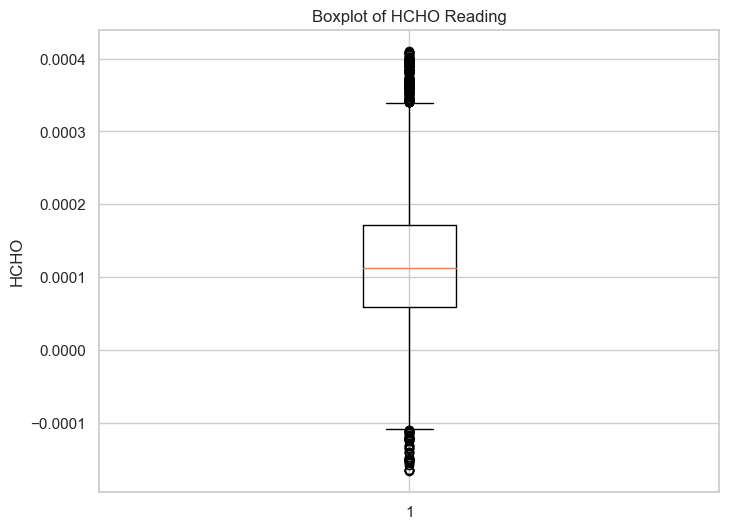

In [29]:
plt.figure(figsize=(8,6))
plt.boxplot(dataset_pd['HCHO reading'])
plt.title("Boxplot of HCHO Reading")
plt.ylabel('HCHO')
plt.show()

In [30]:
dataset_pd.to_csv('artifacts\\preprocessed_dataset.csv', index=False)

## Pre-process the new dataset

In [31]:
weather_data_all = spark.read.csv("dataset\\3660159.csv", header=True, inferSchema=True)
weather_data_all.show()

+-----------+--------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|          NAME|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+--------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-02| 0.0|  78|NULL|  72|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-03| 0.0|  81|  87|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-04| 0.0|  83|  88|  69|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-05| 0.0|  84|  90|  65|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-06| 0.0|  82|  88|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-07| 0.0|  80|  89|  68|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-08| 0.0|  82|  90|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-09| 0.0|  83|  89|  71|
|CEM00043441|KURUNEGA

In [32]:
weather_data_all.describe().show()

+-------+-----------+-------------+------------------+------------------+-----------------+-------------------+-----------------+-----------------+-----------------+
|summary|    STATION|         NAME|          LATITUDE|         LONGITUDE|        ELEVATION|               PRCP|             TAVG|             TMAX|             TMIN|
+-------+-----------+-------------+------------------+------------------+-----------------+-------------------+-----------------+-----------------+-----------------+
|  count|       8745|         8745|              8745|              8745|             8745|               8708|             8745|             7786|             7099|
|   mean|       NULL|         NULL|7.5812132647230674|  80.4034928530589|403.3592910234396|0.21783532384014434|77.96752429959977|85.32995119445158|71.87885617692633|
| stddev|       NULL|         NULL|0.6307164077580714|0.5218081221622476|742.7836994328425| 0.5646333588181337|8.903587849276528|9.064695434736201|9.451778941005836|
|   

In [33]:
weather_data = weather_data_all[weather_data_all['NAME'].isin(['COLOMBO, CE', 'KURUNEGALA, CE', 'NUWARA ELIYA, CE'])]
weather_data.show()

+-----------+--------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|          NAME|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+--------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-02| 0.0|  78|NULL|  72|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-03| 0.0|  81|  87|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-04| 0.0|  83|  88|  69|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-05| 0.0|  84|  90|  65|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-06| 0.0|  82|  88|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-07| 0.0|  80|  89|  68|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-08| 0.0|  82|  90|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-09| 0.0|  83|  89|  71|
|CEM00043441|KURUNEGA

In [34]:
weather_data.describe().show()

+-------+-----------+----------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|    STATION|            NAME|           LATITUDE|         LONGITUDE|        ELEVATION|              PRCP|              TAVG|              TMAX|              TMIN|
+-------+-----------+----------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|       5230|            5230|               5230|              5230|             5230|              5213|              5230|              4647|              4304|
|   mean|       NULL|            NULL|  7.107295411089954| 80.33294646271268|673.1738049713193|0.2464070592748875| 74.95181644359465| 82.25930707983646|  68.7746282527881|
| stddev|       NULL|            NULL|0.25158971653017653|0.3702828680524849|861.0759664769597|0.5698688442602576|10.221189800123925|10.1710

In [35]:
print("Checking for null values")
weather_data.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in weather_data.columns]).show()

Checking for null values
+-------+----+--------+---------+---------+----+----+----+----+----+
|STATION|NAME|LATITUDE|LONGITUDE|ELEVATION|DATE|PRCP|TAVG|TMAX|TMIN|
+-------+----+--------+---------+---------+----+----+----+----+----+
|      0|   0|       0|        0|        0|   0|  17|   0| 583| 926|
+-------+----+--------+---------+---------+----+----+----+----+----+



In [36]:
filled_weather_data = fill_with_last_and_next(weather_data, "DATE", "PRCP")
filled_weather_data = fill_with_last_and_next(filled_weather_data, "DATE", "TMAX")
filled_weather_data = fill_with_last_and_next(filled_weather_data, "DATE", "TMIN")


In [37]:
print("Checking for null values after filling")
filled_weather_data.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in filled_weather_data.columns]).show()

Checking for null values after filling
+-------+----+--------+---------+---------+----+----+----+----+----+
|STATION|NAME|LATITUDE|LONGITUDE|ELEVATION|DATE|PRCP|TAVG|TMAX|TMIN|
+-------+----+--------+---------+---------+----+----+----+----+----+
|      0|   0|       0|        0|        0|   0|   0|   0|   0|   0|
+-------+----+--------+---------+---------+----+----+----+----+----+



In [48]:
filled_weather_data.describe().show()

+-------+-----------+----------------+-------------------+-------------------+-----------------+------------------+-----------------+-----------------+------------------+
|summary|    STATION|            NAME|           LATITUDE|          LONGITUDE|        ELEVATION|              PRCP|             TAVG|             TMAX|              TMIN|
+-------+-----------+----------------+-------------------+-------------------+-----------------+------------------+-----------------+-----------------+------------------+
|  count|       5230|            5230|               5230|               5230|             5230|              5230|             5230|             5230|              5230|
|   mean|       NULL|            NULL|  7.107295411090079|  80.33294646272003|673.1738049713193| 0.245791586998086|74.95181644359465|81.40038240917782| 68.58967495219885|
| stddev|       NULL|            NULL|0.25158971653017526|0.37028286805254185|861.0759664769591|0.5690999481387017|10.22118980012384|10.318059142

In [51]:
filled_weather_data_pd = filled_weather_data.toPandas()

KURUNEGALA_data = filled_weather_data_pd[filled_weather_data_pd['NAME'] == 'KURUNEGALA, CE']
COLOMBO_data = filled_weather_data_pd[filled_weather_data_pd['NAME'] == 'COLOMBO, CE']
NUWARA_ELIYA_data = filled_weather_data_pd[filled_weather_data_pd['NAME'] == 'NUWARA ELIYA, CE']

Kurunegala_Proper_pd = dataset_pd[dataset_pd['Location'] == 'Kurunegala Proper']
Colombo_Proper_pd = dataset_pd[dataset_pd['Location'] == 'Colombo Proper']
Nuwara_Eliya_Proper_pd = dataset_pd[dataset_pd['Location'] == 'Nuwara Eliya Proper']


Kurunegala_merged_data = pd.merge(Kurunegala_Proper_pd, KURUNEGALA_data, left_on=['Current Date'], right_on=['DATE'])
Colombo_merged_data = pd.merge(Colombo_Proper_pd, KURUNEGALA_data, left_on=['Current Date'], right_on=['DATE'])
Nuwara_Eliya_merged_data = pd.merge(Nuwara_Eliya_Proper_pd, KURUNEGALA_data, left_on=['Current Date'], right_on=['DATE'])


new_preprocessed_dataset = pd.concat([Kurunegala_merged_data, Colombo_merged_data, Nuwara_Eliya_merged_data], ignore_index=True)
new_preprocessed_dataset.drop("NAME", axis=1, inplace=True)
new_preprocessed_dataset.drop("DATE", axis=1, inplace=True)

new_preprocessed_dataset

,HCHO reading,Location,Current Date,Next Date,STATION,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN
0,0.000120,Kurunegala Proper,2022-08-12,2022-08-13,CEM00043441,7.467,80.367,116.0,0.00,82,89,79
1,0.000120,Kurunegala Proper,2021-06-21,2021-06-22,CEM00043441,7.467,80.367,116.0,0.00,84,91,78
2,0.000120,Kurunegala Proper,2021-05-30,2021-05-31,CEM00043441,7.467,80.367,116.0,0.00,83,90,78
3,0.000120,Kurunegala Proper,2021-07-24,2021-07-25,CEM00043441,7.467,80.367,116.0,0.09,78,83,56
4,0.000120,Kurunegala Proper,2021-05-27,2021-05-28,CEM00043441,7.467,80.367,116.0,0.82,80,88,74
...,...,...,...,...,...,...,...,...,...,...,...,...
5107,0.000118,Nuwara Eliya Proper,2021-01-28,2021-01-29,CEM00043441,7.467,80.367,116.0,0.00,81,89,73
5108,0.000118,Nuwara Eliya Proper,2023-11-13,2023-11-14,CEM00043441,7.467,80.367,116.0,0.40,79,85,74
5109,0.000118,Nuwara Eliya Proper,2021-07-06,2021-07-07,CEM00043441,7.467,80.367,116.0,0.01,82,91,78
5110,0.000118,Nuwara Eliya Proper,2021-11-30,2021-12-01,CEM00043441,7.467,80.367,116.0,3.35,78,90,73


In [52]:
new_preprocessed_dataset.describe()

,HCHO reading,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN
count,5112.000000,5.112000e+03,5.112000e+03,5112.0,5112.000000,5112.000000,5112.000000,5112.000000
mean,0.000125,7.467000e+00,8.036700e+01,116.0,0.239143,81.657864,88.169014,72.177817
std,0.000092,1.110332e-13,8.982139e-12,0.0,0.597011,2.704106,6.888240,7.146528
min,-0.000165,7.467000e+00,8.036700e+01,116.0,0.000000,69.000000,61.000000,44.000000
25%,0.000063,7.467000e+00,8.036700e+01,116.0,0.000000,80.000000,87.000000,72.000000
50%,0.000118,7.467000e+00,8.036700e+01,116.0,0.000000,82.000000,90.000000,74.000000
75%,0.000181,7.467000e+00,8.036700e+01,116.0,0.180000,83.000000,92.000000,76.000000
max,0.000409,7.467000e+00,8.036700e+01,116.0,7.430000,92.000000,101.000000,83.000000


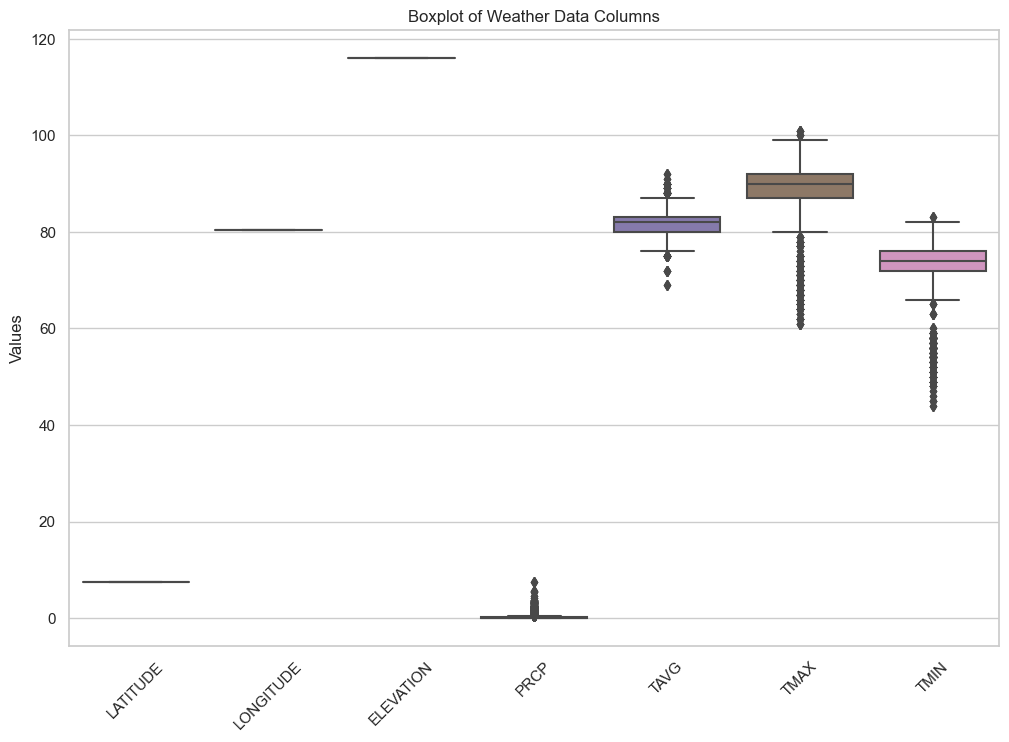

In [55]:
columns_of_interest = ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'PRCP', 'TAVG', 'TMAX', 'TMIN']

plt.figure(figsize=(12, 8))
sns.boxplot(data=new_preprocessed_dataset[columns_of_interest], orient='v')
plt.title('Boxplot of Weather Data Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()


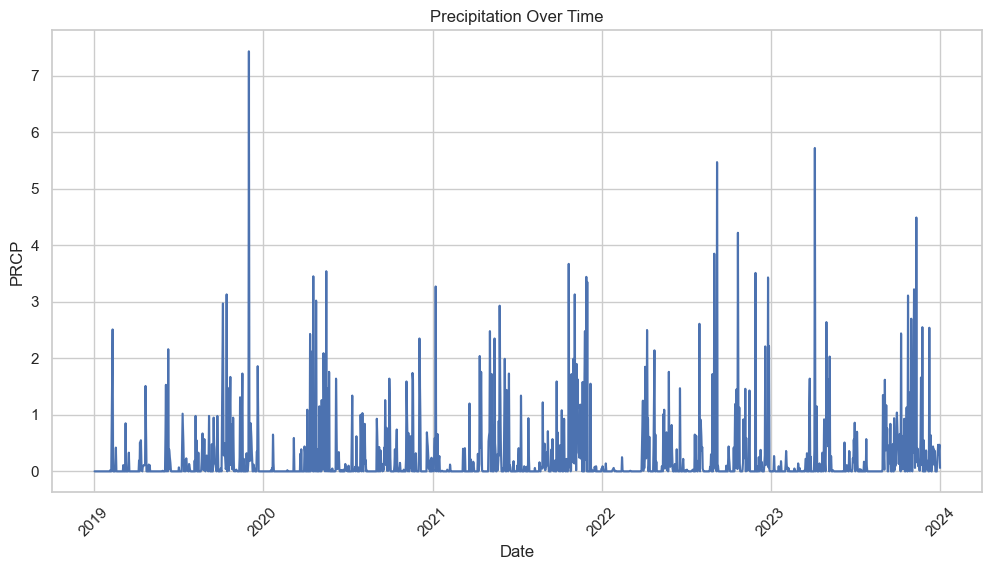

In [63]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Current Date', y='PRCP', data=new_preprocessed_dataset)
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('PRCP')
plt.xticks(rotation=45)
plt.show()

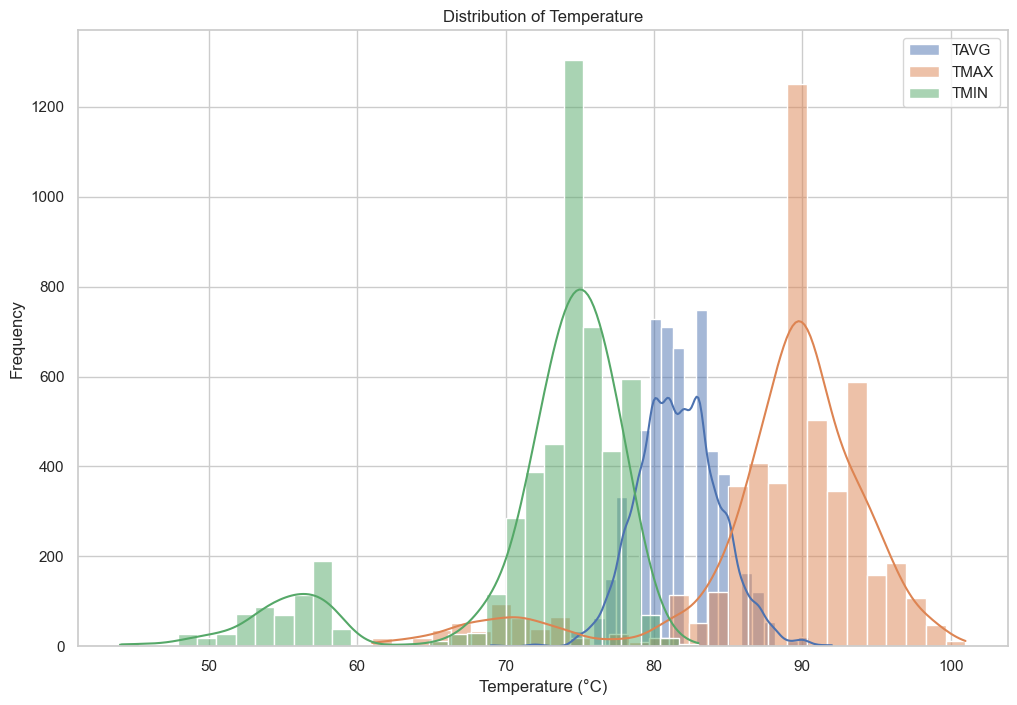

In [61]:
temp_columns = ['TAVG', 'TMAX', 'TMIN']
plt.figure(figsize=(12, 8))
for col in temp_columns:
    sns.histplot(new_preprocessed_dataset[col], bins=30, kde=True, label=col, alpha=0.5)
plt.title('Distribution of Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [64]:
new_preprocessed_dataset.to_csv('artifacts\\external_factors_dataset.csv', index=False)